<a href="https://colab.research.google.com/github/DamianaBuono/Pipeline-per-l-analisi-semantica-e-la-valutazione-degli-errori-di-pronuncia-nella-lingua-Thai/blob/main/EsperimentiSulModello.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip uninstall -y transformers accelerate sentence-transformers

!pip install --no-cache-dir transformers==4.55.2

!pip install --no-cache-dir datasets evaluate accelerate jiwer
!pip install torchaudio --quiet

!pip install torchaudio transformers datasets soundfile
!apt-get install -y ffmpeg
!pip install rouge_score
!pip install seaborn matplotlib

!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121





Found existing installation: transformers 4.57.0
Uninstalling transformers-4.57.0:
  Successfully uninstalled transformers-4.57.0
Found existing installation: accelerate 1.10.1
Uninstalling accelerate-1.10.1:
  Successfully uninstalled accelerate-1.10.1
Found existing installation: sentence-transformers 5.1.1
Uninstalling sentence-transformers-5.1.1:
  Successfully uninstalled sentence-transformers-5.1.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 131.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 327.5 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.1

In [ ]:
!pip install jiwer

Test Modello su testset semplice

In [ ]:
import torch
import evaluate
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datasets import load_from_disk
from transformers import AutoProcessor, AutoModelForCTC

# === CONFIG ===
MODEL_DIR = "/content/drive/MyDrive/TesiMaggistrale/audiErrati/wav2vec2_finetuned_th_erroriTotal"
DATASET_DIR = "/content/drive/MyDrive/TesiMaggistrale/audiErrati/modello_finetunato_th_errori"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# === CARICA MODELLO E PROCESSOR ===
processor = AutoProcessor.from_pretrained(MODEL_DIR)
model = AutoModelForCTC.from_pretrained(MODEL_DIR).to(DEVICE)

# === CARICA DATASET TEST ===
dataset = load_from_disk(DATASET_DIR)
test_dataset = dataset["test"]

# === FUNZIONE DI TRASCRIZIONE ===
def transcribe(batch):
    inputs = processor(batch["input_values"], sampling_rate=16000, return_tensors="pt", padding=True)
    with torch.no_grad():
        logits = model(inputs.input_values.to(DEVICE)).logits
    pred_ids = torch.argmax(logits, dim=-1)
    batch["pred_str"] = processor.batch_decode(pred_ids, group_tokens=True)

    # decode delle labels
    label_ids = []
    for lab in batch["labels"]:
        ids = [id if id != -100 else processor.tokenizer.pad_token_id for id in lab]
        label_ids.append(ids)
    batch["label_str"] = processor.batch_decode(label_ids, group_tokens=False)

    # strip per evitare problemi di spazi
    batch["pred_str"] = [s.strip() for s in batch["pred_str"]]
    batch["label_str"] = [s.strip() for s in batch["label_str"]]

    return batch

# === TRASCRIZIONE ===
results = test_dataset.map(transcribe, batched=True, batch_size=4)
predictions = results["pred_str"]
references = results["label_str"]

# === METRICHE PRINCIPALI ===
cer_metric = evaluate.load("cer")
cer = cer_metric.compute(predictions=predictions, references=references)

# Precision, Recall, F1
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="micro")

# === STAMPA RISULTATI ===
print("📊 Metriche sul test set:")

print(f"CER: {cer:.4f}")
print(f"Char Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")


ModuleNotFoundError: No module named 'evaluate'

**RQ1** Test completo sulle **tipologie** di modifiche usando il cer medio per ogniuno

Metriche sul test set:
CER medio toni: 0.1738
CER medio vocali: 0.1622
CER medio consonanti: 0.1529
Toni: W=0.9503, p=0.6721
 → Distribuzione normale
Vocali: W=0.9390, p=0.5415
 → Distribuzione normale
Consonanti: W=0.9273, p=0.4222
 → Distribuzione normale

📊 ANOVA one-way: F=1.0187, p=0.3745
Nessuna differenza significativa rilevata


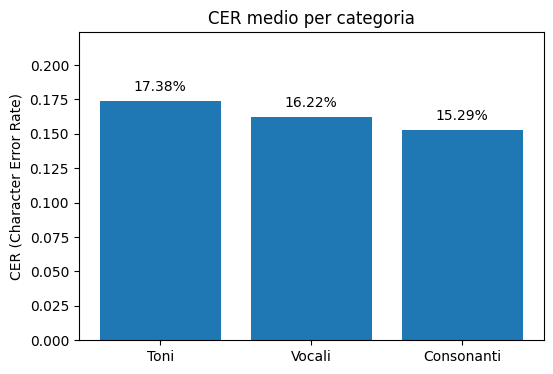

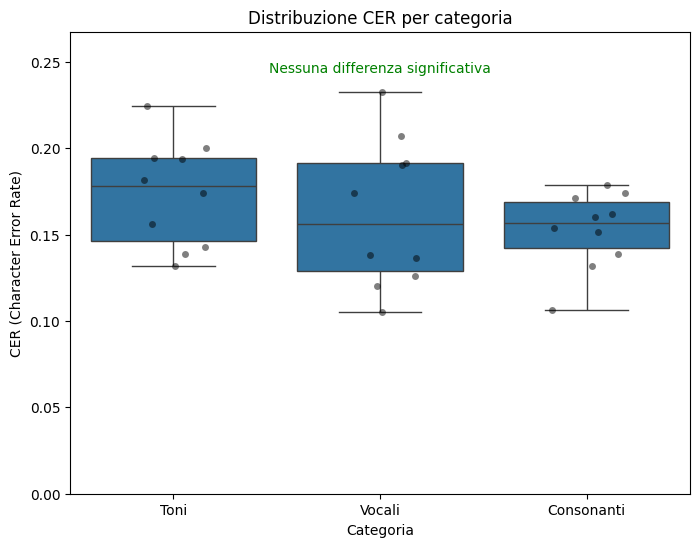


Dataframe riassuntivo per tabella:
    Categoria  CER_medio  Shapiro_W  Shapiro_p
0        Toni   0.173779   0.950306   0.672123
1      Vocali   0.162174   0.938962   0.541523
2  Consonanti   0.152878   0.927341   0.422249


In [ ]:
import torch
import pandas as pd
import librosa
from transformers import AutoProcessor, AutoModelForCTC
import evaluate
import seaborn as sns
import numpy as np
import jiwer
import matplotlib.pyplot as plt
from scipy.stats import shapiro, f_oneway

# === CONFIG ===
MODEL_DIR = "/content/drive/MyDrive/TesiMaggistrale/audiErrati/wav2vec2_finetuned_th_erroriTotal"
CSV_FILE_tono = "/content/drive/MyDrive/TesiMaggistrale/TestSuTipologia/testset_tono.csv"
CSV_FILE_vocali = "/content/drive/MyDrive/TesiMaggistrale/TestSuTipologia/testset_vocale.csv"
CSV_FILE_consonanti = "/content/drive/MyDrive/TesiMaggistrale/TestSuTipologia/testset_consonante.csv"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TARGET_SR = 16000

# === CARICA MODELLO E PROCESSOR ===
processor = AutoProcessor.from_pretrained(MODEL_DIR)
model = AutoModelForCTC.from_pretrained(MODEL_DIR).to(DEVICE)

# === CARICA CSV ===
df_toni = pd.read_csv(CSV_FILE_tono)
df_vocali = pd.read_csv(CSV_FILE_vocali)
df_consonanti = pd.read_csv(CSV_FILE_consonanti)

# === FUNZIONE DI CARICAMENTO AUDIO ===
def load_audio(path, target_sr=TARGET_SR):
    audio, sr = librosa.load(path, sr=target_sr, mono=True)
    return audio

# === TRASCRIZIONE AUDIO ===
def transcribe_audio(audio):
    inputs = processor(audio, sampling_rate=TARGET_SR, return_tensors="pt", padding=True)
    with torch.no_grad():
        logits = model(inputs.input_values.to(DEVICE)).logits
    pred_ids = torch.argmax(logits, dim=-1)
    pred_str = processor.batch_decode(pred_ids, group_tokens=True)[0].strip()
    return pred_str.replace(" ", "")

# === CALCOLO CER ===
cer_metric = evaluate.load("cer")

def compute_cer_list(preds, refs):
    return [jiwer.cer(r, p) for p, r in zip(preds, refs)]

# === TRASCRIZIONI E CER ===
def process_category(df):
    preds, refs = [], []
    for _, row in df.iterrows():
        audio = load_audio(row["audio_path"])
        pred = transcribe_audio(audio)
        preds.append(pred)
        refs.append(row["trascrizione_errata"])
    cer_list = compute_cer_list(preds, refs)
    cer_mean = np.mean(cer_list)
    return preds, refs, cer_list, cer_mean

preds_toni, refs_toni, cer_toni_list, cer_toni_mean = process_category(df_toni)
preds_vocali, refs_vocali, cer_vocali_list, cer_vocali_mean = process_category(df_vocali)
preds_consonanti, refs_consonanti, cer_consonanti_list, cer_consonanti_mean = process_category(df_consonanti)

# === STAMPA METRICHE MEDIE ===
print("Metriche sul test set:")
print(f"CER medio toni: {cer_toni_mean:.4f}")
print(f"CER medio vocali: {cer_vocali_mean:.4f}")
print(f"CER medio consonanti: {cer_consonanti_mean:.4f}")

# === TEST DI NORMALITÀ SHAPIRO-WILK ===
shapiro_results = {}
for cat_name, cer_list in zip(["Toni", "Vocali", "Consonanti"],
                              [cer_toni_list, cer_vocali_list, cer_consonanti_list]):
    W, p_value = shapiro(cer_list)
    shapiro_results[cat_name] = (W, p_value)
    print(f"{cat_name}: W={W:.4f}, p={p_value:.4f}")
    if p_value > 0.05:
        print(f" → Distribuzione normale")
    else:
        print(f" → Distribuzione NON normale")

# === ANOVA ONE-WAY ===
F, p_anova = f_oneway(cer_toni_list, cer_vocali_list, cer_consonanti_list)
print(f"\n📊 ANOVA one-way: F={F:.4f}, p={p_anova:.4f}")
if p_anova < 0.05:
    print("Differenze significative tra le categorie")
else:
    print("Nessuna differenza significativa rilevata")

# === GRAFICO A BARRE CER MEDI ===
categories = ["Toni", "Vocali", "Consonanti"]
values = [cer_toni_mean, cer_vocali_mean, cer_consonanti_mean]

plt.figure(figsize=(6,4))
bars = plt.bar(categories, values)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.005, f"{val:.2%}",
             ha='center', va='bottom', fontsize=10)
plt.ylabel("CER (Character Error Rate)")
plt.title("CER medio per categoria")
plt.ylim(0, max(values)+0.05)
plt.show()

# === BOXPLOT + STRIP PLOT DISTRIBUZIONE CER ===
df_plot = pd.DataFrame({
    "CER": cer_toni_list + cer_vocali_list + cer_consonanti_list,
    "Categoria": ["Toni"]*len(cer_toni_list) + ["Vocali"]*len(cer_vocali_list) + ["Consonanti"]*len(cer_consonanti_list)
})

plt.figure(figsize=(8,6))
sns.boxplot(x="Categoria", y="CER", data=df_plot)
sns.stripplot(x="Categoria", y="CER", data=df_plot, color="black", alpha=0.5, jitter=0.2)

plt.title("Distribuzione CER per categoria")
plt.ylabel("CER (Character Error Rate)")
plt.ylim(0, max(df_plot["CER"])*1.15)

# Annotazione risultato ANOVA
if p_anova < 0.05:
    plt.text(1, max(df_plot["CER"])*1.05, "Differenze significative (p<0.05)",
             ha='center', fontsize=10, color='red')
else:
    plt.text(1, max(df_plot["CER"])*1.05, "Nessuna differenza significativa",
             ha='center', fontsize=10, color='green')

plt.show()

# === DATAFRAME RIASSUNTIVO PER TABELLA ===
df_summary = pd.DataFrame({
    "Categoria": ["Toni", "Vocali", "Consonanti"],
    "CER_medio": [cer_toni_mean, cer_vocali_mean, cer_consonanti_mean],
    "Shapiro_W": [shapiro_results["Toni"][0], shapiro_results["Vocali"][0], shapiro_results["Consonanti"][0]],
    "Shapiro_p": [shapiro_results["Toni"][1], shapiro_results["Vocali"][1], shapiro_results["Consonanti"][1]]
})
print("\nDataframe riassuntivo per tabella:")
print(df_summary)


**RQ2** Esperimento sulla **quantità di errori**: da 1 fino  10  errori introdotti

CER medio per 1 errori: 0.1675 | Shapiro-Wilk p=0.4410 (Normale)
CER medio per 2 errori: 0.1770 | Shapiro-Wilk p=0.1562 (Normale)
CER medio per 3 errori: 0.1774 | Shapiro-Wilk p=0.1361 (Normale)
CER medio per 4 errori: 0.1808 | Shapiro-Wilk p=0.3183 (Normale)
CER medio per 5 errori: 0.1946 | Shapiro-Wilk p=0.2147 (Normale)
CER medio per 6 errori: 0.2111 | Shapiro-Wilk p=0.0361 (Non normale)
CER medio per 7 errori: 0.1796 | Shapiro-Wilk p=0.3696 (Normale)
CER medio per 8 errori: 0.3615 | Shapiro-Wilk p=0.4269 (Normale)
CER medio per 9 errori: 0.3849 | Shapiro-Wilk p=0.2689 (Normale)
CER medio per 10 errori: 0.3565 | Shapiro-Wilk p=0.1377 (Normale)

Correlazione scelta: Spearman | coeff=0.891, p=0.001


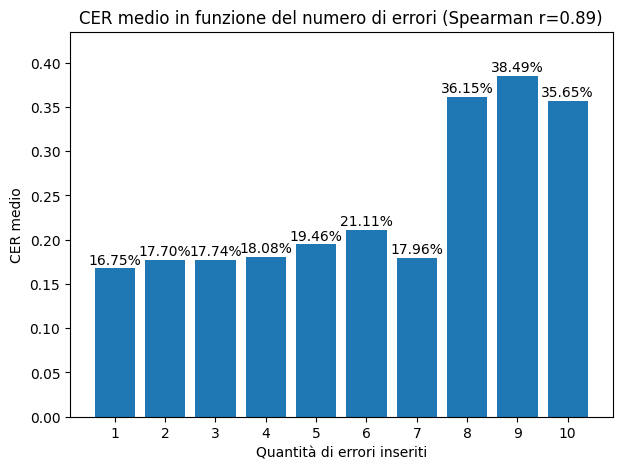

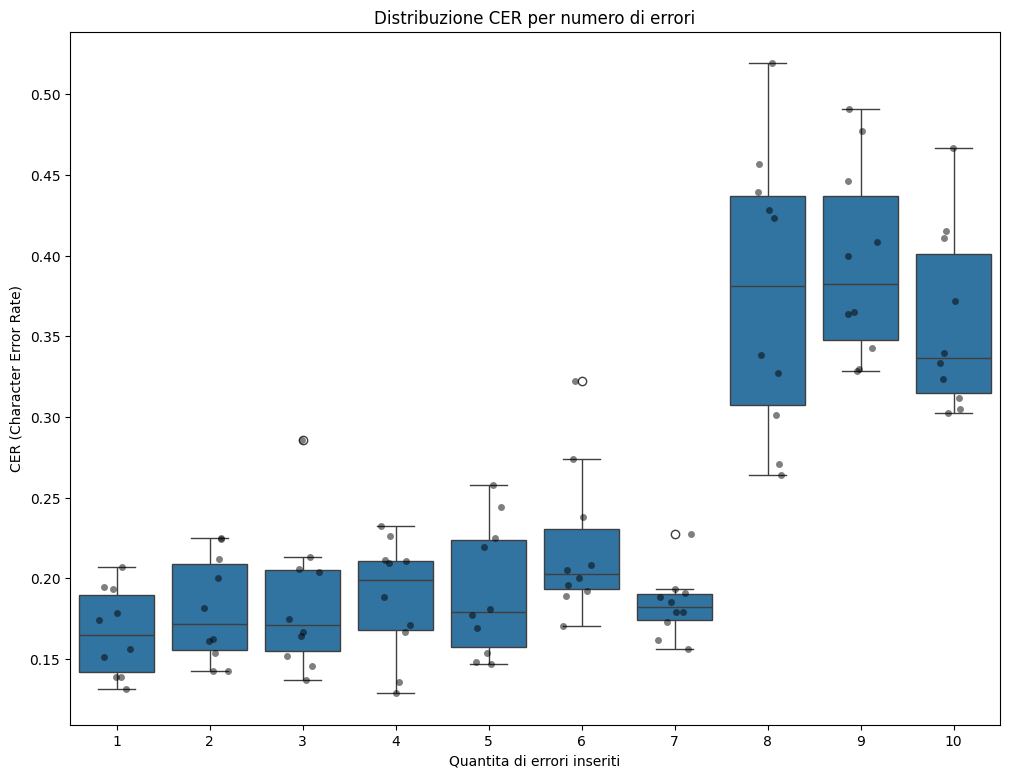

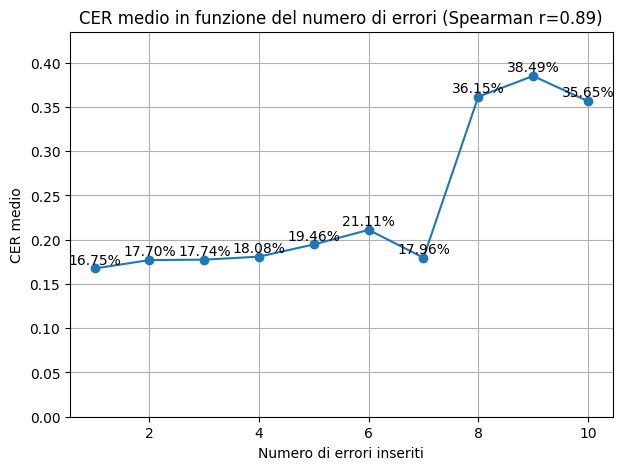

In [ ]:
import torch
import pandas as pd
import librosa
from transformers import AutoProcessor, AutoModelForCTC
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
import jiwer
from scipy.stats import shapiro, pearsonr, spearmanr

# === CONFIG ===
MODEL_DIR = "/content/drive/MyDrive/TesiMaggistrale/audiErrati/wav2vec2_finetuned_th_erroriTotal"
CSV_DIR = "/content/drive/MyDrive/TesiMaggistrale/TestSuTotaleErrori/"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TARGET_SR = 16000

# === CARICA MODELLO E PROCESSOR ===
processor = AutoProcessor.from_pretrained(MODEL_DIR)
model = AutoModelForCTC.from_pretrained(MODEL_DIR).to(DEVICE)

# === FUNZIONE DI CARICAMENTO AUDIO ===
def load_audio(path, target_sr=TARGET_SR):
    audio, sr = librosa.load(path, sr=target_sr, mono=True)
    return audio

# === FUNZIONE DI TRASCRIZIONE AUDIO ===
def transcribe_audio(audio):
    inputs = processor(audio, sampling_rate=TARGET_SR, return_tensors="pt", padding=True)
    with torch.no_grad():
        logits = model(inputs.input_values.to(DEVICE)).logits
    pred_ids = torch.argmax(logits, dim=-1)
    pred_str = processor.batch_decode(pred_ids, group_tokens=True)[0].strip()
    return pred_str.replace(" ", "")

# === Funzione per calcolare CER per ogni frase e CER medio ===
def compute_cer_for_csv(csv_file):
    df = pd.read_csv(csv_file)
    preds, refs = [], []
    for _, row in df.iterrows():
        audio = load_audio(row["audio_path"])
        pred = transcribe_audio(audio)
        preds.append(pred)
        refs.append(row["trascrizione_errata"])
    cer_metric = evaluate.load("cer")
    cer_mean = cer_metric.compute(predictions=preds, references=refs)
    cer_list = [jiwer.cer(r, p) for r, p in zip(refs, preds)]
    return cer_mean, cer_list

# === Ciclo sui CSV da 1 a 10 errori ===
num_errori = list(range(1, 11))
cer_means = []
cer_lists = []

# Per Shapiro-Wilk
shapiro_results = []

for n in num_errori:
    csv_file = f"{CSV_DIR}testset_{n}_errori.csv"
    cer_mean, cer_list = compute_cer_for_csv(csv_file)
    cer_means.append(cer_mean)
    cer_lists.append(cer_list)

    # Test di Shapiro-Wilk
    stat, p_value = shapiro(cer_list)
    shapiro_results.append((stat, p_value))

    normality = "Normale" if p_value > 0.05 else "Non normale"
    print(f"CER medio per {n} errori: {cer_mean:.4f} | Shapiro-Wilk p={p_value:.4f} ({normality})")

# === Preparazione dati per correlazione ===
df_plot = pd.DataFrame({
    "CER": sum(cer_lists, []),
    "NumErrori": sum([[n]*len(lst) for n, lst in zip(num_errori, cer_lists)], [])
})

# Controllo normalità complessiva dei CER medi
stat, p_value = shapiro(cer_means)
if p_value > 0.05:
    corr_type = "Pearson"
    corr_coef, corr_p = pearsonr(num_errori, cer_means)
else:
    corr_type = "Spearman"
    corr_coef, corr_p = spearmanr(num_errori, cer_means)

print(f"\nCorrelazione scelta: {corr_type} | coeff={corr_coef:.3f}, p={corr_p:.3f}")

# === BAR PLOT CER medio vs numero errori ===
plt.figure(figsize=(7,5))
bars = plt.bar([str(n) for n in num_errori], cer_means)
plt.xlabel("Quantità di errori inseriti")
plt.ylabel("CER medio")
plt.title(f"CER medio in funzione del numero di errori ({corr_type} r={corr_coef:.2f})")
plt.ylim(0, max(cer_means)+0.05)
for bar, val in zip(bars, cer_means):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.005, f"{val:.2%}", ha='center')
plt.show()

# === BOXPLOT + STRIP PLOT distribuzione CER per numero errori ===
plt.figure(figsize=(12,9))
sns.boxplot(x="NumErrori", y="CER", data=df_plot)
sns.stripplot(x="NumErrori", y="CER", data=df_plot, color="black", alpha=0.5, jitter=0.2)
plt.xlabel("Quantita di errori inseriti")
plt.ylabel("CER (Character Error Rate)")
plt.title("Distribuzione CER per numero di errori")
plt.show()

# === LINE PLOT CER medio vs numero errori ===
plt.figure(figsize=(7,5))
plt.plot(num_errori, cer_means, marker="o")
plt.xlabel("Numero di errori inseriti")
plt.ylabel("CER medio")
plt.title(f"CER medio in funzione del numero di errori ({corr_type} r={corr_coef:.2f})")
plt.ylim(0, max(cer_means)+0.05)
for x, y in zip(num_errori, cer_means):
    plt.text(x, y + 0.005, f"{y:.2%}", ha='center')
plt.grid(True)
plt.show()


**RQ3** Test sul grado si **similarità**!


ANALISI MODELLO 2 - Relazione tra numero di errori e alterazione semantica
Numero campioni analizzati: 325

Statistiche descrittive generali:
       gravita  semantic_similarity
count  325.000              325.000
mean     2.748                0.916
std      2.654                0.101
min      0.000                0.380
25%      1.000                0.882
50%      2.000                0.952
75%      4.000                0.984
max     13.000                1.000

Test di normalità per ciascun livello di gravità:
Nessun errore: W=0.650, p=0.00000
Lieve: W=0.733, p=0.00000
Media: W=0.846, p=0.00000
Grave: W=0.869, p=0.00231

Levene (varianze uguali tra gruppi): W=1.298, p=0.27504


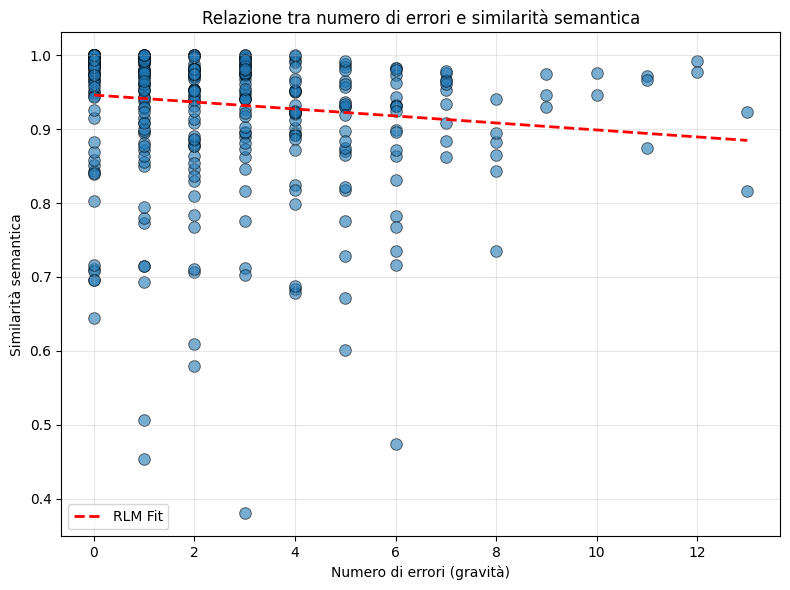

/tmp/ipython-input-3204028199.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


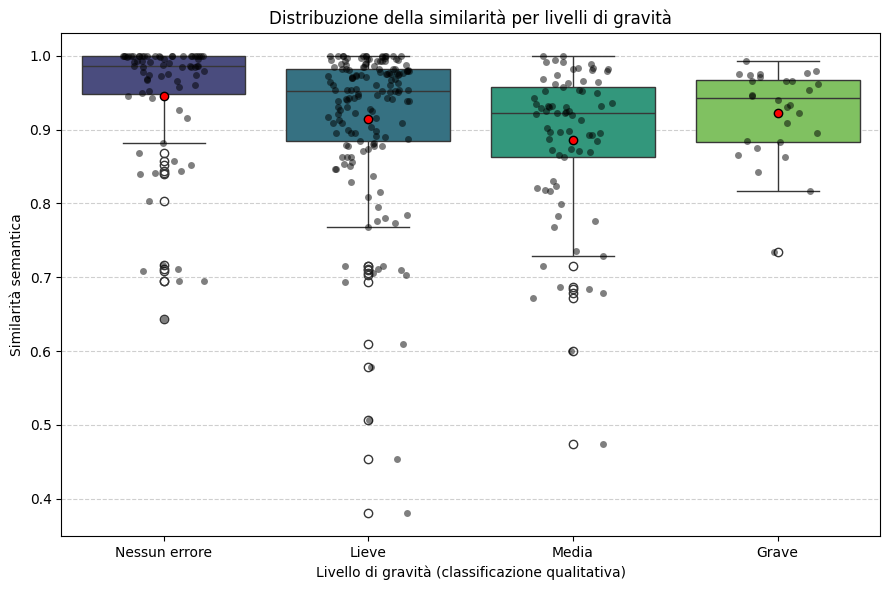


Correlazione tra gravità e similarità semantica (Spearman)
Spearman: ρ = -0.3014, p = 0.00000
Correlazione negativa: all’aumentare degli errori, la similarità semantica tende a diminuire.

Test di differenza tra livelli di gravità (Kruskal-Wallis)
H = 36.217, p = 0.00000
Differenze significative tra almeno due livelli di gravità.

Analisi di regressione robusta (RLM): similarità ~ gravità
                     Robust linear Model Regression Results                    
Dep. Variable:     semantic_similarity   No. Observations:                  325
Model:                             RLM   Df Residuals:                      323
Method:                           IRLS   Df Model:                            1
Norm:                           HuberT                                         
Scale Est.:                        mad                                         
Cov Type:                           H1                                         
Date:                 Wed, 15 Oct 2025         

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import spearmanr, kruskal, shapiro, levene
import statsmodels.api as sm

# === CONFIGURAZIONE ===
CSV_OUTPUT = "/content/drive/MyDrive/TesiMaggistrale/AudiDerivatiCorretti/TestRQ3/risultati.csv"
FIGURE_DIR = "/content/drive/MyDrive/TesiMaggistrale/frontmatter/figure/RQ3/"

os.makedirs(FIGURE_DIR, exist_ok=True)

if not os.path.exists(CSV_OUTPUT):
    raise FileNotFoundError(f"File CSV non trovato: {CSV_OUTPUT}")

# === LETTURA DATI ===
df = pd.read_csv(CSV_OUTPUT)
df["semantic_similarity"] = df["semantic_similarity"].astype(float)
df["gravita"] = df["gravita"].astype(float)

print("\nANALISI MODELLO 2 - Relazione tra numero di errori e alterazione semantica")
print(f"Numero campioni analizzati: {len(df)}")

# === DEFINIZIONE ORDINE LOGICO DELLA GRAVITÀ TESTUALE ===
ordine_gravita = ["Nessun errore", "Lieve", "Media", "Grave"]
df["gravita_testuale"] = pd.Categorical(
    df["gravita_testuale"],
    categories=ordine_gravita,
    ordered=True
)

# === STATISTICHE DESCRITTIVE ===
desc_stats = df[["gravita", "semantic_similarity"]].describe()
print("\nStatistiche descrittive generali:")
print(desc_stats.round(3))

# === TEST DI NORMALITÀ E OMOSCHEDASTICITÀ ===
print("\nTest di normalità per ciascun livello di gravità:")
for level in ordine_gravita:
    data = df[df["gravita_testuale"] == level]["semantic_similarity"].dropna()
    if len(data) > 3:  # requisito minimo per il test di Shapiro
        stat, p = shapiro(data)
        print(f"{level}: W={stat:.3f}, p={p:.5f}")
    else:
        print(f"{level}: troppo pochi dati per eseguire il test")

levene_test = levene(*[df[df["gravita_testuale"]==level]["semantic_similarity"].dropna()
                        for level in ordine_gravita if level in df["gravita_testuale"].unique()])

print(f"\nLevene (varianze uguali tra gruppi): W={levene_test.statistic:.3f}, p={levene_test.pvalue:.5f}")

# === VISUALIZZAZIONI ===

# 1️ Scatter plot con regressione robusta (RLM)
plt.figure(figsize=(8,6))
sns.scatterplot(x="gravita", y="semantic_similarity", data=df, alpha=0.6, s=70, edgecolor="k")

# Regressione robusta RLM
X = sm.add_constant(df["gravita"])
y = df["semantic_similarity"]
rlm_model = sm.RLM(y, X, M=sm.robust.norms.HuberT()).fit()
x_pred = pd.DataFrame({'gravita': sorted(df["gravita"].unique())})
x_pred = sm.add_constant(x_pred)
y_pred = rlm_model.predict(x_pred)
plt.plot(sorted(df["gravita"].unique()), y_pred, color='red', linestyle='--', linewidth=2, label='RLM Fit')

plt.xlabel("Numero di errori (gravità)")
plt.ylabel("Similarità semantica")
plt.title("Relazione tra numero di errori e similarità semantica")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "scatter_rlm.png"), dpi=300)
plt.show()

# 2️ Boxplot per livelli qualitativi di gravità (mediana e outlier)
plt.figure(figsize=(9,6))
sns.boxplot(
    x="gravita_testuale",
    y="semantic_similarity",
    data=df,
    order=ordine_gravita,
    palette="viridis",
    showmeans=True,
    meanprops={"marker":"o","markerfacecolor":"red","markeredgecolor":"black"}
)
sns.stripplot(
    x="gravita_testuale",
    y="semantic_similarity",
    data=df,
    order=ordine_gravita,
    color="black",
    alpha=0.5,
    jitter=0.2
)
plt.xlabel("Livello di gravità (classificazione qualitativa)")
plt.ylabel("Similarità semantica")
plt.title("Distribuzione della similarità per livelli di gravità")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "boxplot_gravita.png"), dpi=300)
plt.show()

# === CORRELAZIONE NON PARAMETRICA ===
spearman_corr, spearman_p = spearmanr(df["semantic_similarity"], df["gravita"])
print("\nCorrelazione tra gravità e similarità semantica (Spearman)")
print(f"Spearman: ρ = {spearman_corr:.4f}, p = {spearman_p:.5f}")
if spearman_corr < 0:
    print("Correlazione negativa: all’aumentare degli errori, la similarità semantica tende a diminuire.")
else:
    print("Correlazione positiva inattesa — controllare la coerenza dei dati.")

# === TEST DIFFERENZA TRA GRUPPI (KRUSKAL-WALLIS) ===
groups = [
    df[df["gravita_testuale"] == level]["semantic_similarity"].dropna()
    for level in ordine_gravita if level in df["gravita_testuale"].unique()
]
kruskal_stat, kruskal_p = kruskal(*groups)
print("\nTest di differenza tra livelli di gravità (Kruskal-Wallis)")
print(f"H = {kruskal_stat:.3f}, p = {kruskal_p:.5f}")
if kruskal_p < 0.05:
    print("Differenze significative tra almeno due livelli di gravità.")
else:
    print("Nessuna differenza significativa tra i livelli di gravità.")

# === REGRESSIONE ROBUSTA (RLM) SUMMARY ===
print("\nAnalisi di regressione robusta (RLM): similarità ~ gravità")
print(rlm_model.summary())
print(f"\nCoefficiente di gravità: β = {rlm_model.params['gravita']:.4f} (relazione negativa se <0)")

print("\n--- Analisi RQ3 completata ---")
